Contents of extracted folder:
HW3.pdf  HWData
Contents of train directory:
accordion  anchor  BACKGROUND_Google  bass    binocular  brain	       buddha	  camera
airplanes  ant	   barrel	      beaver  bonsai	 brontosaurus  butterfly
Contents of test directory:
accordion  anchor  BACKGROUND_Google  bass    binocular  brain	       buddha	  camera
airplanes  ant	   barrel	      beaver  bonsai	 brontosaurus  butterfly
Found 291 images belonging to 15 classes.
Found 127 images belonging to 15 classes.


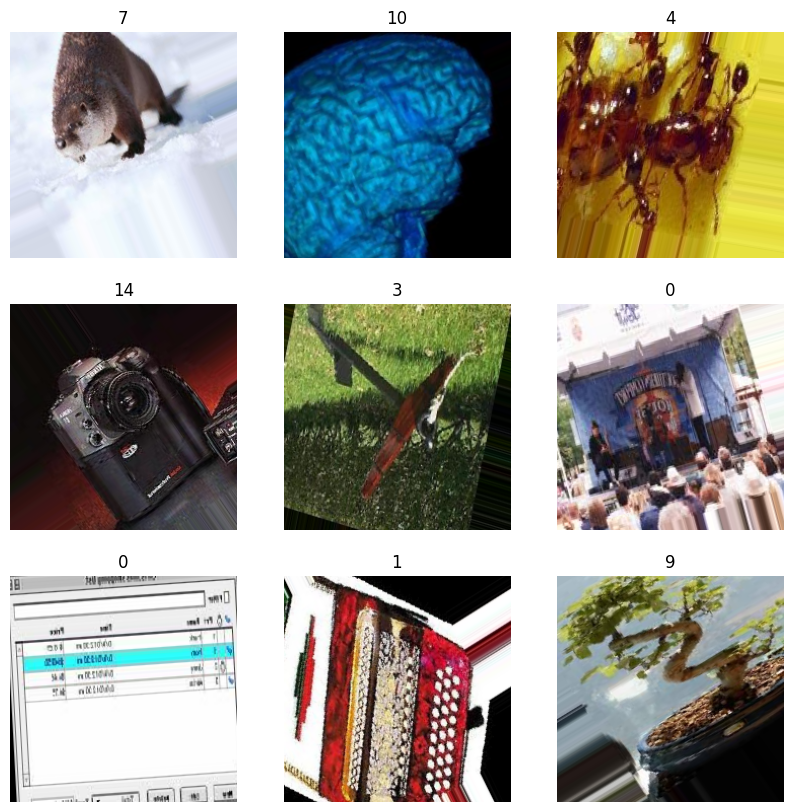

In [133]:
#  Here i Imported the  necessary libraries.
import os
import zipfile
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

# Here i Unziped the dataset
zip_path = '/content/HW3 (2).zip'
extract_folder = '/content/Datas'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Verifying  the content of the directory

print("Contents of extracted folder:")
!ls /content/Datas

# Seting  the paths to training and testing datasets
train_path = "/content/Datas/HWData/train"
test_path = "/content/Datas/HWData/test"

# Check the contents inside train and test directories
print("Contents of train directory:")
!ls {train_path}
print("Contents of test directory:")
!ls {test_path}

# Defining  image size and batch size: Here i just wanted to see the images in 224,224 pixels. I havevent resize the pictures yet.
image_size = (224, 224)
batch_size = 32  # batch(group) size for training

# Setting up ImageDataGenerators for training and testing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

# Here i  Only rescaling(olceklendirme) for test data

test_datagen = ImageDataGenerator(rescale=1./255)

# Prepare data generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical')

# Demonstrating  sample data

for images, labels in train_generator:
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(int(np.argmax(labels[i])))
        plt.axis("off")
    break  # Show one batch
plt.show()



In [134]:



# Stage1: Here it reads all images from related directories
# And then it resizes these images to  64x64 pixels

def process_images(root_dir):
    class_vectors = {}  # It's is dictionary to store vectors for each class

    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg')):
                # Creating the path to the image file
                file_path = os.path.join(root, file)
                # Load the image
                image = Image.open(file_path)
                # Convert image to grayscale and resize it to 64x64
                image = image.convert('L').resize((64, 64))
                # Convert image to numpy array and flatten it
                image_vector = np.array(image).flatten()

                # Identifing the class from the directory name
                class_name = os.path.basename(root)
                if class_name not in class_vectors:
                    class_vectors[class_name] = []
                class_vectors[class_name].append(image_vector)

    # Convert lists to numpy arrays and ensure the format is 4096xn
    for class_name in class_vectors:
        class_vectors[class_name] = np.vstack(class_vectors[class_name]).T

    return class_vectors

# Set the root directory of the images here the root directory is train
root_directory = '/content/Datas/HWData/train'
images_by_class1 = process_images(root_directory)

# Set the root directory of your images here the root directory is test
root_directoryOF_test = '/content/Datas/HWData/test'
images_by_class2 = process_images(root_directoryOF_test)



# Output the shape of the matrices for each class
for class_name, vectors in images_by_class1.items():
    print(f"Class: {class_name}, Matrix shape: {vectors.shape}")

print()

# Output the shape of the matrices for each class
print("test Directorie's Contents's informations  ")
for class_name, vectors in images_by_class2.items():
    print(f"Class: {class_name}, Matrix shape: {vectors.shape}")


Class: barrel, Matrix shape: (4096, 10)
Class: BACKGROUND_Google, Matrix shape: (4096, 94)
Class: anchor, Matrix shape: (4096, 9)
Class: bass, Matrix shape: (4096, 12)
Class: brontosaurus, Matrix shape: (4096, 10)
Class: bonsai, Matrix shape: (4096, 27)
Class: ant, Matrix shape: (4096, 9)
Class: butterfly, Matrix shape: (4096, 19)
Class: beaver, Matrix shape: (4096, 10)
Class: camera, Matrix shape: (4096, 11)
Class: accordion, Matrix shape: (4096, 12)
Class: binocular, Matrix shape: (4096, 8)
Class: airplanes, Matrix shape: (4096, 21)
Class: brain, Matrix shape: (4096, 21)
Class: buddha, Matrix shape: (4096, 18)

test Directorie's Contents's informations  
Class: barrel, Matrix shape: (4096, 4)
Class: BACKGROUND_Google, Matrix shape: (4096, 46)
Class: anchor, Matrix shape: (4096, 4)
Class: bass, Matrix shape: (4096, 4)
Class: brontosaurus, Matrix shape: (4096, 3)
Class: bonsai, Matrix shape: (4096, 11)
Class: ant, Matrix shape: (4096, 4)
Class: butterfly, Matrix shape: (4096, 8)
Class:

In [135]:
# Stage2: Select Eigenvalues and Eigenvectors of (PCA).

# PCA function that computes covariance, eigenvalues, and eigenvectors
def perform_pca(data):
    pca_results = {}
    for class_name, vectors in data.items():
        # Mean center the data
        mean_centered = vectors - np.mean(vectors, axis=0)
        # Here it  calculates the covariance matrix
        covariance_matrix = np.cov(mean_centered, rowvar=False)
        # Calculate eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
        # Sort eigenvalues in descending order and select the top 3 eigenvectors
        sorted_indices = np.argsort(eigenvalues)[::-1]
        top_eigenvectors = eigenvectors[:, sorted_indices[:3]]
        pca_results[class_name] = top_eigenvectors
    return pca_results

# Process images from both directories
train_directory = '/content/Datas/HWData/train'
test_directory = '/content/Datas/HWData/test'
train_data = process_images(train_directory)
test_data = process_images(test_directory)

# Perform PCA
train_pca_results = perform_pca(train_data)
test_pca_results = perform_pca(test_data)

# Output PCA results
print("Train Directory PCA Results:")
for class_name, eigenvectors in train_pca_results.items():
    print(f"Class: {class_name}, Eigenvectors shape: {eigenvectors.shape}")

print("\nTest Directory PCA Results:")
for class_name, eigenvectors in test_pca_results.items():
    print(f"Class: {class_name}, Eigenvectors shape: {eigenvectors.shape}")

Train Directory PCA Results:
Class: barrel, Eigenvectors shape: (10, 3)
Class: BACKGROUND_Google, Eigenvectors shape: (94, 3)
Class: anchor, Eigenvectors shape: (9, 3)
Class: bass, Eigenvectors shape: (12, 3)
Class: brontosaurus, Eigenvectors shape: (10, 3)
Class: bonsai, Eigenvectors shape: (27, 3)
Class: ant, Eigenvectors shape: (9, 3)
Class: butterfly, Eigenvectors shape: (19, 3)
Class: beaver, Eigenvectors shape: (10, 3)
Class: camera, Eigenvectors shape: (11, 3)
Class: accordion, Eigenvectors shape: (12, 3)
Class: binocular, Eigenvectors shape: (8, 3)
Class: airplanes, Eigenvectors shape: (21, 3)
Class: brain, Eigenvectors shape: (21, 3)
Class: buddha, Eigenvectors shape: (18, 3)

Test Directory PCA Results:
Class: barrel, Eigenvectors shape: (4, 3)
Class: BACKGROUND_Google, Eigenvectors shape: (46, 3)
Class: anchor, Eigenvectors shape: (4, 3)
Class: bass, Eigenvectors shape: (4, 3)
Class: brontosaurus, Eigenvectors shape: (3, 3)
Class: bonsai, Eigenvectors shape: (11, 3)
Class: a

In [136]:
# Stage3: Extract PCA features by using Eigenvectors.
# Define the function to project PCA features
def project_pca_features(data, pca_results):
    pca_features = {}
    for class_name, vectors in data.items():
        # Retrieve the top 3 eigenvectors for the class
        eigenvectors = pca_results[class_name]
        # Project the data (4096xn) onto the top 3 eigenvectors (nx3)
        # Resultant projected features will be 4096x3
        projected_features = np.dot(vectors, eigenvectors)
        pca_features[class_name] = projected_features
    return pca_features

# Assuming train_data and train_pca_results are already defined and calculated
train_pca_features = project_pca_features(train_data, train_pca_results)
test_pca_features = project_pca_features(test_data, test_pca_results)

# Output the new dimensions for each class in the train and test sets
print("Train PCA Projected Features:")
for class_name, features in train_pca_features.items():
    print(f"Class: {class_name}, Projected Features Shape: {features.shape}")

print("\nTest PCA Projected Features:")
for class_name, features in test_pca_features.items():
    print(f"Class: {class_name}, Projected Features Shape: {features.shape}")
print()

# Example code to print the number of samples per class- I added this line of code my own.
print("Number of samples per class in the test set:")
for class_name, vectors in test_data.items():
    print(f"Class: {class_name}, Number of samples: {vectors.shape[1]}")



Train PCA Projected Features:
Class: barrel, Projected Features Shape: (4096, 3)
Class: BACKGROUND_Google, Projected Features Shape: (4096, 3)
Class: anchor, Projected Features Shape: (4096, 3)
Class: bass, Projected Features Shape: (4096, 3)
Class: brontosaurus, Projected Features Shape: (4096, 3)
Class: bonsai, Projected Features Shape: (4096, 3)
Class: ant, Projected Features Shape: (4096, 3)
Class: butterfly, Projected Features Shape: (4096, 3)
Class: beaver, Projected Features Shape: (4096, 3)
Class: camera, Projected Features Shape: (4096, 3)
Class: accordion, Projected Features Shape: (4096, 3)
Class: binocular, Projected Features Shape: (4096, 3)
Class: airplanes, Projected Features Shape: (4096, 3)
Class: brain, Projected Features Shape: (4096, 3)
Class: buddha, Projected Features Shape: (4096, 3)

Test PCA Projected Features:
Class: barrel, Projected Features Shape: (4096, 3)
Class: BACKGROUND_Google, Projected Features Shape: (4096, 3)
Class: anchor, Projected Features Shape

In [137]:

# Stage4: Test an Image

def predict_class_label(test_image_path, pca_results, pca_features):
    # Step 1: Read and process the test image
    test_vector = read_process_image(test_image_path)
    if test_vector is None:
        print("Failed to process the test image.")
        return None

    # Step 2: Project the test image onto the PCA eigenvector space
    # We need to repeat the test vector to match the dimensions used in training
    num_samples = min(len(eigenvectors) for eigenvectors in pca_results.values())  # Find minimum n for eigenvector dimension nx3
    repeated_test_vector = np.tile(test_vector, (num_samples, 1)).T  # Repeat the test vector to form a 4096xn matrix
    projected_test_image = np.dot(repeated_test_vector, pca_results[list(pca_results.keys())[0]])  # Use eigenvectors from any class just for dimension match

    # Step 3: Compute distances to all training class PCA features
    distances = {}
    for class_name, train_features in pca_features.items():
        # Ensure both matrices are aligned; this requires train_features to be 4096x3
        if projected_test_image.shape[1] != train_features.shape[1]:
            continue  # Skip if dimensions mismatch
        # Compute the sum of absolute distances
        distance = np.sum(np.abs(projected_test_image - train_features))
        distances[class_name] = distance

    # Here it  determines the class with the minimum distance
    if distances:
        predicted_class = min(distances, key=distances.get)
        print(f"Predicted Class: {predicted_class}, with distances: {distances}")
        return predicted_class
    else:
        print("No valid distances were computed.")
        return None

# Example usage:
test_image_path = '/content/Datas/HWData/test/airplanes/image_0750.jpg'
predicted_class = predict_class_label(test_image_path, train_pca_results, train_pca_features)



ValueError: shapes (4096,8) and (10,3) not aligned: 8 (dim 1) != 10 (dim 0)